# Afinidade de Artistas-Decada com Machine Learning e NLP

> Deep Learning Researcher

> Artigo de Base - https://www.sciencedirect.com/science/article/pii/S2543925125000130

> Dataset utilizado - https://www.kaggle.com/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics

O seguinte projeto tem como objetivo realizar uma análise de afinidade do produto musical de determinados artistas com suas respectivas épocas, dissecando a história da música por décadas para analisar quais artistas mais estavam alinhados com o padrão de sua época e quais momentos da história possuíriam a maior tendência de afinidade por artista.

### Trabalho Relacionado

O artigo de base utilizado para correlacionar as métricas do trabalho foi:

*Aspect-based sentiment evolution and its correlation with review rounds in multi-round peer reviews: A deep learning approach*

Esse artigo possui a seguinte hipótese: *Últimos rounds de reviews para artigos tendem a ter avaliações mais positivas*

Para tal foram comparados diversos modelos de NLP, em via de escolher o que melhor realizaria a análise de sentimento requerida para o projeto.

Através do melhor modelo escolhido, foi realizado o estudo e retiradas as devidas conclusões dos dados encontrados.

### Objetivos e Métricas

Utilizando como base o trabalho de referência citado, o seguinte trabalho terá a seguinte hipótese como ponto de partida:

*Artistas contemporâneos possuem maior tendência a possuírem líricas semelhantes que artistas antigos*

Através dessa hipótese serão testados alguns modelos de NLP, e a partir deles serão utilizados como métricas de decisão accuracy e macro-f1.

>Embora no artigo utilizem outras métricas como macro-p e macro-r, as principais métricas para decisão foram as citadas acima.

A partir do modelo gerado, serão extraídos resultados que auxiliem a compreender a questão e chegar a uma conclusão para a hipótese.

## Tratamento do Dataset Original

O dataset escolhido contempla parte consíderavel das músicas do spotify, com uma referência para o id da música no spotify.

Nessa seção serão extraídos, através do id do spotify e a API própria da empresa o ano e a popularidade de cada faixa.

Tais dados serão salvos em um novo dataset **music_dataset_new** e eventualmente tratados para o **clean_music_dataset**.

>Inicialização das Chaves para API
- Gemini (opcional)
- Spotify (necessárias para construção do dataset)

In [24]:
import os
from dotenv import load_dotenv
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
SPOTIFY_SECRET = os.getenv('SPOTIFY_SECRET')
SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')

>Executar caso ainda não tenha o dataset baixado via Kagglehub

In [2]:
import kagglehub

path = kagglehub.dataset_download("bwandowando/spotify-songs-with-attributes-and-lyrics")

>Executar caso o dataset **music_dataset_new** não esteja completo

A API do spotify comporta 5000 requisições diárias em batchs de 50 músicas, contemplando 250000 músicas diariamente.

Como o dataset possui mais de 900000 músicas, é necessário realizar a execução do trecho de código por alguns dias para preencher o dataset.

O trecho de código é feito para poder ser executado diversas vezes, de modo que os novos dados são salvados automaticamente no **music_dataset_new** e apenas os dados ainda não obtidos são adicionados ao dataset.

Caso deseje fazer uma execução de teste, recomendo que altere a varíavel *LIMIT* que limitará o número de músicas tratadas e extraídas.

Por erros desconhecidos em minha chave API, não foi possível realizar a conversão de todas as faixas (tempo de espera ficou travado em 24 horas por 1 semana), portanto o projeto foi realizado com um dataset de cerca de 600000 faixas, o que foi considerado satisfatório para a proposta.

In [ ]:
from pathlib import Path
import pandas as pd
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm

path = Path(path)
df = pd.read_csv(path / 'songs_with_attributes_and_lyrics.csv')

ARQUIVO_SAIDA = "music_dataset_new.csv"
LIMIT = -1 
BATCH_SIZE = 50
SAVE_FACTOR = 50000

client_credentials_manager = SpotifyClientCredentials(
    client_id=SPOTIFY_CLIENT_ID,
    client_secret=SPOTIFY_SECRET
)
sp = Spotify(client_credentials_manager=client_credentials_manager)

if LIMIT > 0:
    df = df.head(LIMIT).copy()

try:
    df_saida = pd.read_csv(ARQUIVO_SAIDA)
except FileNotFoundError:
    df_saida = df.copy()
    df_saida['year'] = None
    df_saida['popularity'] = None

ids_faltantes = df.loc[~df['id'].isin(df_saida['id'])].copy()
if not ids_faltantes.empty:
    ids_faltantes['year'] = None
    ids_faltantes['popularity'] = None
    df_saida = pd.concat([df_saida, ids_faltantes], ignore_index=True)

df_para_processar = df_saida[df_saida['year'].isna() | df_saida['popularity'].isna()].copy()

def get_years_and_popularity_batch(track_ids):
    years = []
    popularity = []
    try:
        results = sp.tracks(track_ids)
        for track in results['tracks']:
            if track:
                year = int(track['album']['release_date'][:4]) if 'release_date' in track['album'] else None
                years.append(year)
                popularity.append(track.get('popularity', None))
            else:
                years.append(None)
                popularity.append(None)
    except Exception as e:
        print(f"Erro no batch: {e}")
        years = [None] * len(track_ids)
        popularity = [None] * len(track_ids)
    return years, popularity

for i in tqdm(range(0, len(df_para_processar), BATCH_SIZE)):
    batch = df_para_processar.iloc[i:i+BATCH_SIZE]
    ids_para_buscar = batch['id'].tolist()
    anos, popularidade = get_years_and_popularity_batch(ids_para_buscar)

    df_saida.loc[df_saida['id'].isin(ids_para_buscar), 'year'] = anos
    df_saida.loc[df_saida['id'].isin(ids_para_buscar), 'popularity'] = popularidade

    if i % SAVE_FACTOR == 0:
        df_saida.to_csv(ARQUIVO_SAIDA, index=False)

df_saida.to_csv(ARQUIVO_SAIDA, index=False)

  0%|          | 1/7613 [00:31<65:59:18, 31.21s/it]WARNING:root:Your application has reached a rate/request limit. Retry will occur after: 86400


>Executar caso o dataset **clean_music_dataset** não esteja completo

No código abaixo o dataset, já com as devidas colunas representando ano e popularidade, é tratado.
Para tal as letras são tratadas de modo que possam ser melhor interpretadas pelos modelos de linguagem e a coluna decade é críada, uma vez que o escopo do projeto visa dividir os artistas por decada.

In [4]:
import pandas as pd
ARQUIVO_SAIDA = "music_dataset_new.csv"

In [5]:
df = pd.read_csv(ARQUIVO_SAIDA)

df = df[['year', 'lyrics', 'name', 'artists', 'popularity']]
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])
df['decade'] = (df['year'] // 10 * 10).astype(int)
df['lyrics'] = df['lyrics'].str.lower()
df['lyrics'] = df['lyrics'].str.replace(r'\n', ' ', regex=True) 
df['lyrics'] = df['lyrics'].fillna('')
df = df[df['decade'] != 0]

df.to_csv("clean_music_dataset.csv", index=False)
df.head()

,year,lyrics,name,artists,popularity,decade
0,2016.0,"he said he came from jamaica, he owned a coup...",!,['HELLYEAH'],0.0,2010
1,2019.0,"fucked a bitch, now she running with my kids ...",!!,Yxngxr1,32.0,2010
2,2019.0,"oh, my god, i'm going crazy",!!! - Interlude,['Glowie'],0.0,2010
3,2000.0,continuamente se extraña la gente si no puede ...,!!De Repente!!,['Rosendo'],7.0,2000
4,1986.0,continuamente se extraña la gente si no puede ...,!!De Repente!!,['Rosendo'],16.0,1980


# Treinamento do Modelo

No seguinte trecho será realizado:
- Tratamentos para balancear o dataset
- Treinamento de 4 modelos alternativos
- Comparação e escolha do melhor modelo
- Salvamento dos pesos por token

In [1]:
import pandas as pd

df = pd.read_csv("clean_music_dataset.csv")
df.head()

,year,lyrics,name,artists,popularity,decade
0,2016.0,"he said he came from jamaica, he owned a coup...",!,['HELLYEAH'],0.0,2010
1,2019.0,"fucked a bitch, now she running with my kids ...",!!,Yxngxr1,32.0,2010
2,2019.0,"oh, my god, i'm going crazy",!!! - Interlude,['Glowie'],0.0,2010
3,2000.0,continuamente se extraña la gente si no puede ...,!!De Repente!!,['Rosendo'],7.0,2000
4,1986.0,continuamente se extraña la gente si no puede ...,!!De Repente!!,['Rosendo'],16.0,1980


>Algumas letras, emboras tratadas anteriormente, seguiram sem conteúdo, portanto isso é novamente tratado, removendo cerca de 10 músicas sem letras do dataset.

In [2]:
df = df[df['lyrics'].notnull()]

Como pode ser observado, o dataset é extremamente desbalanceado, possuíndo alto volume de dados na década de 2010 e basicamente nenhum volume de dados antes de 1950.

Para melhorar os resultados obtidos, foram realizados dois tratamentos no dataset:
- Máximo de 50000 músicas por década, ordenado por popularidade
- Remoção de músicas de décadas antes de 1950

Essas medidas foram escolhidas pois, para a proposta do trabalho, que pretende analisar as músicas mais impactantes por década, é muito mais valiosa a informação de músicas populares de suas respectivas épocas, não havendo tanta perda em liberar dados de músicas menos populares.
Além disso, embora os anos de 50 a 80 possuam também baixo volume de dados, os mesmos foram mantidos devido a relevância desses períodos históricos na história da música, acreditando que o volume de dados existentes para tais anos poderia ser valioso para o resultado do projeto.

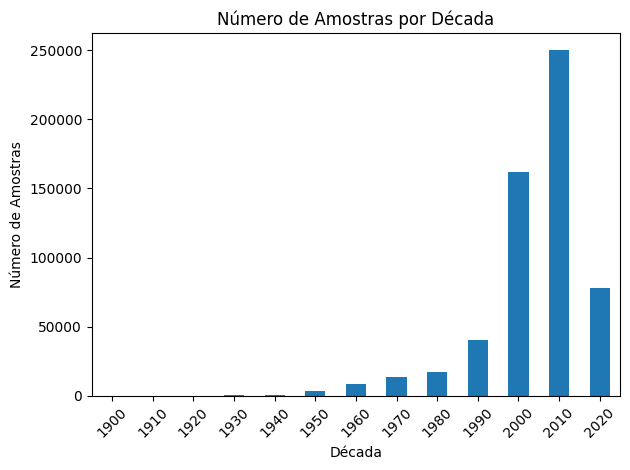

In [ ]:
import matplotlib.pyplot as plt

df['decade'].value_counts().sort_index().plot(kind='bar')
plt.title("Número de Amostras por Década")
plt.xlabel("Década")
plt.ylabel("Número de Amostras")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
limite_por_decada = 50000

df = (
    df.sort_values(by="popularity", ascending=False)
      .groupby("decade", group_keys=False)
      .apply(lambda g: g.head(limite_por_decada))
      .reset_index(drop=True)
)

df = df[df['decade'] > 1940]

C:\Users\cailu\AppData\Local\Temp\ipykernel_26032\1095210393.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.head(limite_por_decada))


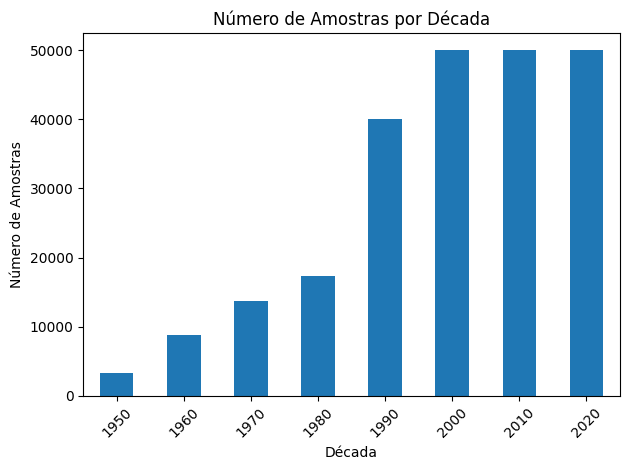

In [20]:
df['decade'].value_counts().sort_index().plot(kind='bar')
plt.title("Número de Amostras por Década")
plt.xlabel("Década")
plt.ylabel("Número de Amostras")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Abaixo é realizada uma comparação entre 4 modelos, identificando qual apresentará melhores resultados para ser utilizado na extração de resultados e conclusões do projeto.

Dentre os modelos testados foram utilizados Logistic Regression, Multinomial Naive Bayes, Linear SVC e XGBoost.

Nota-se que os modelos testados são todos modelos em que é possível identificar o peso das features, uma vez que o projeto depende desse resultado para que conclusões possam ser retiradas.

Como o dataset abrange músicas de diversas línguas foram utilizadas stop-words de diversas línguas na vetorização.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

languages = ['english', 'spanish', 'french', 'german', 'portuguese', 'italian']
multi_stopwords = set()
for lang in languages:
    multi_stopwords.update(stopwords.words(lang))

vectorizer = TfidfVectorizer(max_features=10000, stop_words=list(multi_stopwords))
X = vectorizer.fit_transform(df['lyrics'])

le = LabelEncoder()
y = le.fit_transform(df['decade']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "XGBoost": XGBClassifier(
        eval_metric='mlogloss',
        tree_method='hist'
    ),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Linear SVC": LinearSVC(max_iter=10000),
}

results = []

for name, model in models.items():
    print(f"Treinando {name}...")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\nComparação de Modelos:")
print(results_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cailu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Treinando XGBoost...
Treinando Logistic Regression...
Treinando Multinomial Naive Bayes...
Treinando Linear SVC...

Comparação de Modelos:
                     Model  Accuracy  F1 Score
1      Logistic Regression  0.363210  0.352863
3               Linear SVC  0.357614  0.349093
0                  XGBoost  0.358000  0.342412
2  Multinomial Naive Bayes  0.335406  0.310911


A regressão logística demonstrou os melhores resultados nos testes realizados, tanto em accuracy quanto em f1-score, portanto foi utilizada como modelo de referência para execução do projeto.

Em sequência, o modelo com regressão logística foi retreinado, agora com toda a base de dados, e a partir do mesmo foram extraídos os coeficientes por década para outra estrutura de dados, permitindo que fossem utilizados futuramente.

Segue também uma demonstração das 10 palavras mais impactantes por década.

In [22]:
import numpy as np

clf = LogisticRegression(max_iter=10000)
clf.fit(X, y)

feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_

decades = le.inverse_transform(clf.classes_)

top_words = {}

for i, decade in enumerate(decades):
    top_indices = np.argsort(coefs[i])[-100:]
    top_words[decade] = feature_names[top_indices]

decade_word_weights = {
    decade: dict(zip(feature_names, coefs[i]))
    for i, decade in enumerate(decades)
}

for decade, words in top_words.items():
    print(f"{decade}s: {', '.join(words[:10])}")


1950s: handle, hallelujah, begin, forgetting, stream, sale, gladly, liza, havin, vow
1960s: deed, balloon, carol, cariño, pow, though, spring, belong, penny, complete
1970s: allah, afternoon, hah, lalalala, cariño, pass, pale, taken, tryin, flowing
1980s: satan, price, cheap, knife, powers, danger, cansado, method, kill, incomprehensible
1990s: x4, crucify, thang, peoples, zen, net, props, ak, player, cos
2000s: plague, gangsta, nuh, convencer, gotten, ignored, 너무, despite, indeed, floor
2010s: claro, rato, whiskey, like, sous, weight, bro, pussy, trust, realest
2020s: blessings, diego, ere, adrenaline, vroom, honestly, gana, issues, neck, closure


## Pesquisa de Sentimento com LLM (Opcional)

Fora do escopo do projeto, foi realizado um teste utilizando a IA do google Gemini, requerendo uma análise de sentimento baseado nas 100 palavras mais determinantes por década, para possívelmente poder realizar comparações com o imaginario coletivo de cada época.

Para tal foi pedido que o modelo de LLM retornasse 3 palavras, considerando sentimento e contexto sociocultural, a partir da lista de 100 palavras mais determinantes fornecidas.

In [25]:
import google.generativeai as genai

genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel(model_name="gemini-1.5-flash")

In [26]:
def analisar_sentimento_decada(palavras):
    prompt = f"""
    Você é um analista de sentimentos em letras de músicas.

    Dada a seguinte lista de palavras mais frequentes e relevantes para músicas de uma decada específica, identifique qual sentimento ou clima emocional essas palavras em conjunto refletem sobre o espírito daquela época.

    Palavras: {', '.join(palavras)}

    Analise o sentimento predominante transmitido por essas palavras no contexto de letras musicais da época. 
    Responda com apenas 3 palavras que melhor descrevem o sentimento e contexto sociocultural que pode ser atrelado a determinada década.
    """
    
    response = model.generate_content(prompt)
    return response.text.strip()


In [27]:
analises_sentimento = {}

for decada, palavras in top_words.items():
    sentimento = analisar_sentimento_decada(palavras)
    analises_sentimento[decada] = sentimento

In [28]:
print("\nAnálise de Sentimento por Década:")
for decada, sentimento in analises_sentimento.items():
    print(f"{decada}s: {sentimento}")


Análise de Sentimento por Década:
1950s: Romântico, nostálgico, esperançoso.
1960s: Nostalgia, Otimismo,  Innocência
1970s: Liberdade,  Esperança,  Transgressão
1980s: Rebelião,  violência,  desilusão.
1990s: Agressividade,  materialismo,  rebeldia.
2000s: Agressividade,  Materialismo,  Rebelião.
2010s: Hedonismo,  materialismo,  rebeldia.
2020s: Autodestruição, superficialidade,  ansiedade.


## Geração do Dataset de Afinidade dos Artistas

>Executar caso o dataset **artists_afinity** não esteja completo

Nessa seção é realizado um novo tratamento dos dados, afim de tornar a análise dos resultados mais simples, nesse tratamento foi criado um novo dataset, composto pelas seguintes colunas:
- artista : nome do artista
- decada : decada em que o artista possuía músicas (podendo haver mais de uma linha do mesmo artista, uma para cada década)
- afinidade_com_epoca : score concedido ao artista analisando a correlação das letras de suas músicas com o padrão de sua época
- popularidade : maior score de popularidade obtido por alguma música do artista (utilizado para filtrar artistas mais importantes)

**Afinidade com Época** - Essa medida foi cálculada da seguinte forma:
- Músicas com mais de um artista foram tratadas, de modo que houvesse mais de uma linha por música, uma para cada artista
- Letras dos mesmos artistas foram todas agrupadas em uma mesma string
- Frequência de palavras foi extraído para cada artista por época
- Frequência por palavra foi multiplicado pelo coeficiente da época respectiva

O resultado dessa operação seria o quanto as músicas produzidas pelo artista nessa época estariam alinhadas com o padrão lírico da década.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
import ast

def parse_artists(entry):
    if isinstance(entry, list):
        return entry
    if isinstance(entry, str):
        try:
            val = ast.literal_eval(entry)
            if isinstance(val, list):
                return val
            else:
                return [val]
        except:
            return [entry]
    return [str(entry)]

df['artists'] = df['artists'].apply(parse_artists)
df_exploded = df.explode('artists').rename(columns={'artists': 'artist'})

artista_letras_por_decada = df_exploded.groupby(["artist", "decade"])["lyrics"].apply(lambda x: " ".join(str(t) for t in x))


<unknown>:1: SyntaxWarning: invalid decimal literal


In [30]:
artista_streams_max = df_exploded.groupby("artist")["popularity"].max()

def get_frequencias(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {}
    vectorizer = CountVectorizer(stop_words='english')
    try:
        X = vectorizer.fit_transform([text])
        total = X.sum()
        return dict(zip(vectorizer.get_feature_names_out(), X.toarray()[0] / total))
    except ValueError:
        return {}

frequencias_por_artista_decada = artista_letras_por_decada.apply(get_frequencias)

def calcular_afinidade_combinada(freq_artista, pesos_decada):
    score = 0
    for palavra, freq in freq_artista.items():
        peso = pesos_decada.get(palavra, 0)
        score += freq * peso
    return score

afinidade_resultados = []

for (artista, decada), freq in frequencias_por_artista_decada.items():
    if decada in decade_word_weights:
        score = calcular_afinidade_combinada(freq, decade_word_weights[decada])
        popularidade_label = artista_streams_max.get(artista, 0)
        afinidade_resultados.append({
            "artista": artista,
            "decada": decada,
            "afinidade_com_epoca": score,
            "popularidade": popularidade_label
        })

df_afinidade = pd.DataFrame(afinidade_resultados)
df_afinidade.to_csv("artists_afinity.csv", index=False)


## Análise dos Resultados de Afinidade dos Artistas

Nessa seção é utilizado o novo dataset criado para:
- Encontrar quais são os artistas mais alinhados com sua respectiva época
- Analisar quais épocas possuem os artistas mais alinhados em média
- Discutir possíveis causas desses resultados

In [31]:
df_afinidade = pd.read_csv("artists_afinity.csv")
df_afinidade = df_afinidade.sort_values(by="afinidade_com_epoca", ascending=False)
df_afinidade.head()

,artista,decada,afinidade_com_epoca,popularidade
47448,RetroVision,2010,2.993443,37.0
62933,Wuki,2010,2.697830,72.0
41283,Neitan,2020,2.607891,46.0
47293,Reinier Zonneveld,2020,2.221461,42.0
15275,Dimitri Vegas & Like Mike;Vini Vici;MATTN,2020,2.184391,44.0


In [51]:
def mostrar_afinidade_por_decada(df_afinidade, decada, popularity_percent ,top_n=10):
    popularity_treshold = df_afinidade['popularidade'].quantile(popularity_percent/1000)
    df_filtrado = df_afinidade[df_afinidade['decada'] == decada]
    df_filtrado = df_filtrado[df_filtrado['popularidade'] >= popularity_treshold]

    if df_filtrado.empty:
        print(f"Nenhum dado encontrado para a década {decada}.")
        return

    print(f"\nTop {top_n} artistas mais alinhados com os anos {decada}:")
    top = df_filtrado.sort_values(by='afinidade_com_epoca', ascending=False).head(top_n)
    for i, row in top.iterrows():
        print(f"{row['artista']}: {row['afinidade_com_epoca']:.2f}")

    print(f"\nTop {top_n} artistas menos alinhados com os anos {decada}:")
    bottom = df_filtrado.sort_values(by='afinidade_com_epoca', ascending=True).head(top_n)
    for i, row in bottom.iterrows():
        print(f"{row['artista']}: {row['afinidade_com_epoca']:.2f}")


A função abaixo permite encontrar os top10 e botton10 em alinhamento com a época para cada década, filtrados por um percentil de popularidade de 1 a 999.

Com essa ferramenta é possível analisar quais artistas mais faziam parte de seu respectivo movimento musical, algo como, qual o artista que mais representa a década de 90 ou a década de 60.

In [63]:
decada = 1980
# Popularidade em percentil (0-1000)
popularidade = 960

mostrar_afinidade_por_decada(df_afinidade, decada, popularidade)


Top 10 artistas mais alinhados com os anos 1980:
Survivor: 0.25
Lionel Richie: 0.25
Alphaville: 0.24
Bob Marley & The Wailers: 0.23
Savage: 0.21
Bonnie Tyler: 0.20
Miki Matsubara: 0.19
Queen: 0.19
Roxette: 0.19
AC/DC: 0.19

Top 10 artistas menos alinhados com os anos 1980:
*NSYNC: -0.08
The Monkees: -0.04
John Lennon: -0.03
Travis Tritt: -0.03
The Doobie Brothers: -0.02
Etta James: -0.02
Tammi Terrell: -0.01
Daddy Yankee: -0.01
Earth, Wind & Fire: -0.01
Frank Sinatra: -0.01


In [58]:
import matplotlib.pyplot as plt

def plot_afinidade_por_decada(df_afinidade, treshold):
    decadas = df_afinidade['decada'].unique()
    afinidade_diff = []
    for decada in sorted(decadas):
        df_decada = df_afinidade[df_afinidade['decada'] == decada]
        max_popularity = df_decada['popularidade'].max()
        df_decada = df_decada[df_decada['popularidade'] >= max_popularity * treshold]
        if not df_decada.empty:
            afinidade_diff.append(df_decada['afinidade_com_epoca'].mean())
        else:
            afinidade_diff.append(0)

    plt.figure(figsize=(12, 6))
    plt.bar(sorted(decadas), afinidade_diff, color='skyblue')
    plt.xlabel('Década')
    plt.ylabel('Diferença de Afinidade')
    plt.title('Diferença de Afinidade com a Década por Popularidade')
    plt.xticks(sorted(decadas), rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()


Os gráficos abaixo permitem analisar em quais décadas os artistas mais estavam próximos e mais distantes em termos líricos, possibilitando certas conclusões e análises em função da história da música.

O primeiro gráfico é uma representação da média dos artistas mais populares de suas épocas, enquanto o segundo gráfico trata dos artistas em geral, sem distinção por popularidade.

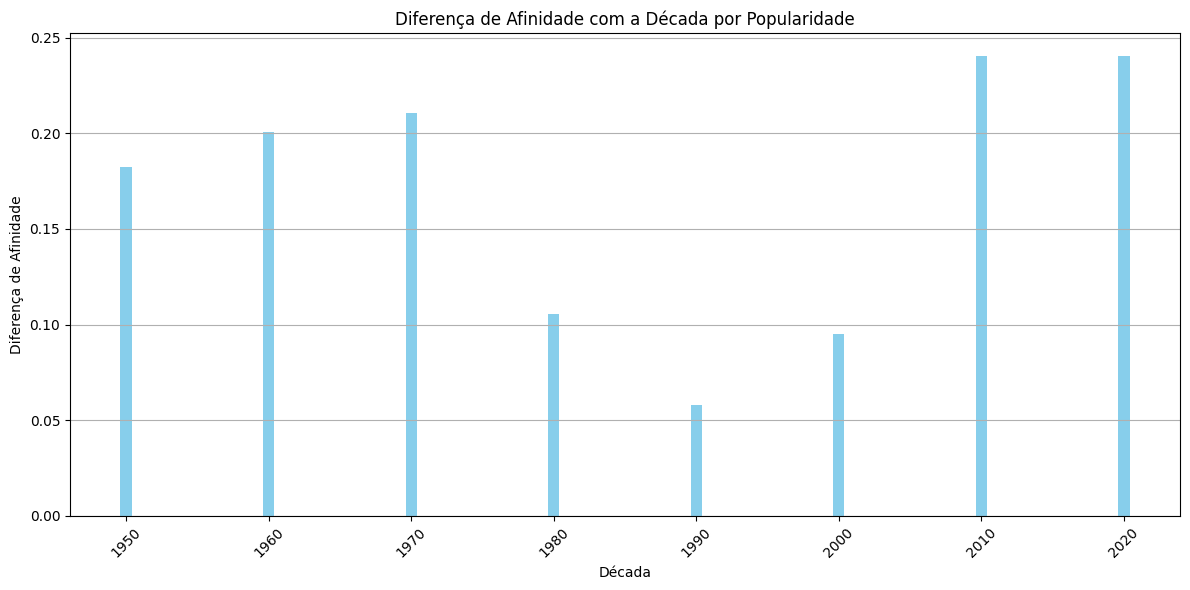

In [38]:
plot_afinidade_por_decada(df_afinidade, 0.9)

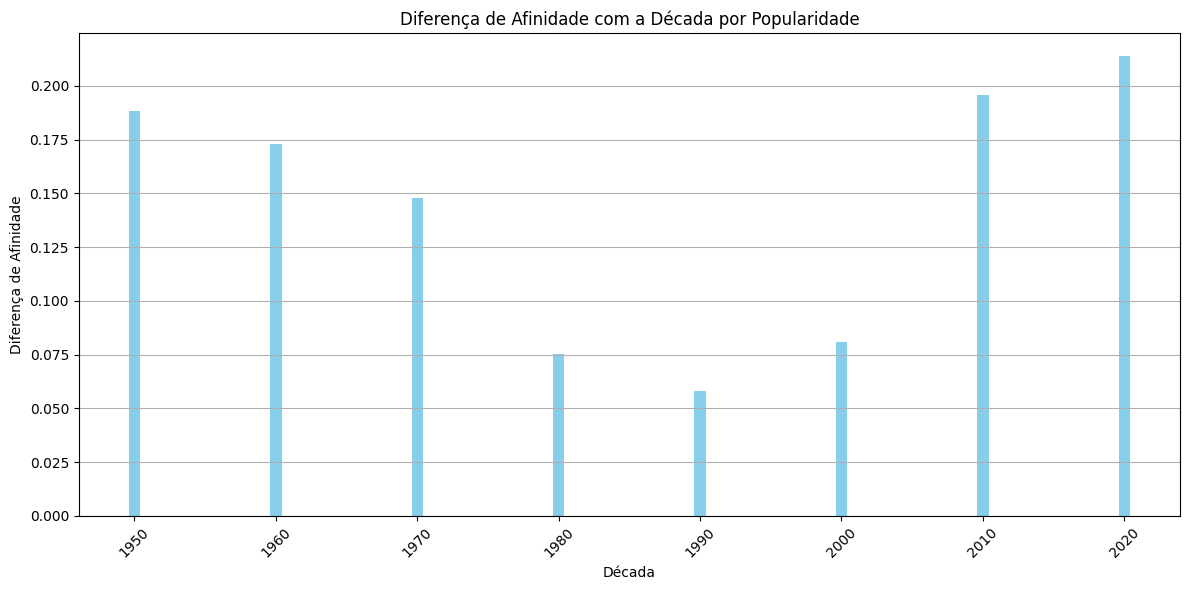

In [39]:
plot_afinidade_por_decada(df_afinidade, 0)

### Conclusão

Os resultados obtidos no projeto podem ser utilizados como evidências interessantes para tratar a hipótese inicial de que artistas contemporâneos possuem maior tendência a possuírem líricas semelhantes que artistas antigos. Para tal, primeiramente há de se considerar os dois gráficos acima como de resultados extremamente semelhantes, portanto não se pode considerar que haja diferenças significativas entre os artistas mais populares e menos populares de suas épocas em termos de afinidade por época.

Analisando os gráficos gerados evidenciando a média de afinidade dos artistas por década pode ser confirmada a hipótese inicial, de que os artistas contemporâneos tendem a possuir maior afinidade por época, uma vez que possuem o maior índice da história nessa métrica, porém não por um crescimento linear, como pode ser observado, ressaltando que não existe um mecanismo que correlacione diretamente as décadas passadas com a afinidade dos artistas para com sua época.

Por outro lado, esse gráfico pode ser analisado através da história da música popular, indicando um mecanismo muito mais provável e possível para os altos níveis de correlação entre artistas. Como pode ser observado, nos anos 50 e 60 também haveria um alto índice de afinidade, que decai para um ponto mínimo nos anos 80 e volta a subir a partir dai para uma nova máxima histórica.

Esse gráfico pode ser interpretado por um movimento de virada na história da música, saindo de um genero extremamente predominante do rock dos anos 50 e 60, para suas variações, como punk e grunge, e movimentos musicais alternativos, como pop e rap, que se tornariam nos anos 2000 o novo movimento predominante.

Por fim, esse trabalho responde a hipótese inicial, ao negar um mecanismo que gere uma tendência a afinidade maior entre artistas com o passar do tempo, e gera novas questões em relação a possíveis mecanismos que acarretem nesse comportamento, assim como o sugerido no parágrafo acima, podendo ser agregado a trabalhos que façam a mesma análise por generos e localidades musicais, a título de exemplo.